In [2]:
!pip install numpy matplotlib sympy > /dev/null 2>&1


---
##### Title: Exploring Gradient Descent Methods
##### Author: Ujjayant Kadian
##### Date: 2025-03-13
---

# Introduction

This notebook explores various gradient descent optimization techniques, analyzing their effectiveness in minimizing a given loss function. The focus is on comparing different step size strategies, particularly in the context of mini-batch Stochastic Gradient Descent (SGD). Through empirical experimentation, we evaluate the impact of batch size, adaptive learning rates, and momentum-based updates on convergence behavior.

## Table of Contents

1. **Setup and Data Generation**
   - Generating synthetic training data
   - Defining loss function

2. **Implementing Mini-batch Stochastic Gradient Descent SGD**
   - SGD Implementation
   - Loss Function Visualization
   - Finite Difference Calculation

3. **Experiments with Gradient Descent**
   - Constant Step Size GD
   - Mini-batch SGD (Batch Size=5)
   - Mini-batch Size Effect
   - Step-Size Effect

4. **Comparing Advanced Optimization Methods**
   - Polyak step size
   - Adaptive learning rates (RMSProp)
   - Momentum-based methods (Heavy Ball)
   - Combined approaches (Adam)
---

## 1. Setup and Data Generation
---

In [19]:
import numpy as np

def generate_trainingdata(m=25):
    return np.array([0,0])+0.25*np.random.randn(m,2)

def f(x, minibatch):
    # loss function sum_{w in training data} f(x,w)
    y=0; count=0
    for w in minibatch:
        z=x-w-1
        y=y+min(20*(z[0]**2+z[1]**2), (z[0]+9)**2+(z[1]+10)**2)   
        count=count+1
    return y/count

# Generate training data
train_data = generate_trainingdata(m=25)

---
## 2. Implementing Mini-batch Stochastic Gradient Descent (SGD)
---

### (a)(i) SGD Implementation
---

In [20]:
class SGDOptimizer:
    def __init__(self, method='constant', **kwargs):
        self.method = method
        self.params = kwargs
        self.state = {}
        
        # Initialize method-specific parameters
        if method == 'rmsprop':
            self.state['cache'] = 0
            self.rho = kwargs.get('rho', 0.9)
        elif method == 'heavyball':
            self.state['velocity'] = 0
            self.momentum = kwargs.get('momentum', 0.9)
        elif method == 'adam':
            self.state['m'] = 0
            self.state['v'] = 0
            self.beta1 = kwargs.get('beta1', 0.9)
            self.beta2 = kwargs.get('beta2', 0.999)
            self.epsilon = kwargs.get('epsilon', 1e-8)
            self.t = 0

    def compute_step(self, grad: np.ndarray) -> float:
        method_functions = {
            'constant': self._constant,
            'polyak': self._polyak,
            'rmsprop': self._rmsprop,
            'heavyball': self._heavyball,
            'adam': self._adam
        }
        return method_functions[self.method](grad)

    def _constant(self, grad):
        return self.params['alpha'] * grad

    def _polyak(self, grad):
        return self.params['gamma'] * ((self.params['f'] - self.params['f_opt']) / (np.linalg.norm(grad)**2 + self.params['epsilon'])) * grad

    def _rmsprop(self, grad):
        self.state['cache'] = self.rho * self.state['cache'] + (1 - self.rho) * grad**2
        return self.params['alpha'] * grad / (np.sqrt(self.state['cache']) + 1e-6)

    def _heavyball(self, grad):
        self.state['velocity'] = self.momentum * self.state['velocity'] - self.params['alpha'] * grad
        return self.state['velocity']

    def _adam(self, grad):
        self.t += 1
        self.state['m'] = self.beta1 * self.state['m'] + (1 - self.beta1) * grad
        self.state['v'] = self.beta2 * self.state['v'] + (1 - self.beta2) * grad**2
        
        # Bias correction
        m_hat = self.state['m'] / (1 - self.beta1**self.t)
        v_hat = self.state['v'] / (1 - self.beta2**self.t)
        
        return self.params['alpha'] * m_hat / (np.sqrt(v_hat) + self.epsilon)

---
**Implementation Explanation:**
- The `SGDOptimizer` class handles different optimization methods through method dispatch
- Each optimization method has its own update rule implemented in separate private functions (similar to the update rules implemented in week-4 assignment)
- State management handles momentum, RMSProp cache, and Adam's moment estimates
- Supports constant step size, Polyak, RMSProp, Heavy Ball (momentum), and Adam methods
---

### (a)(ii) Loss Function Visualization
---

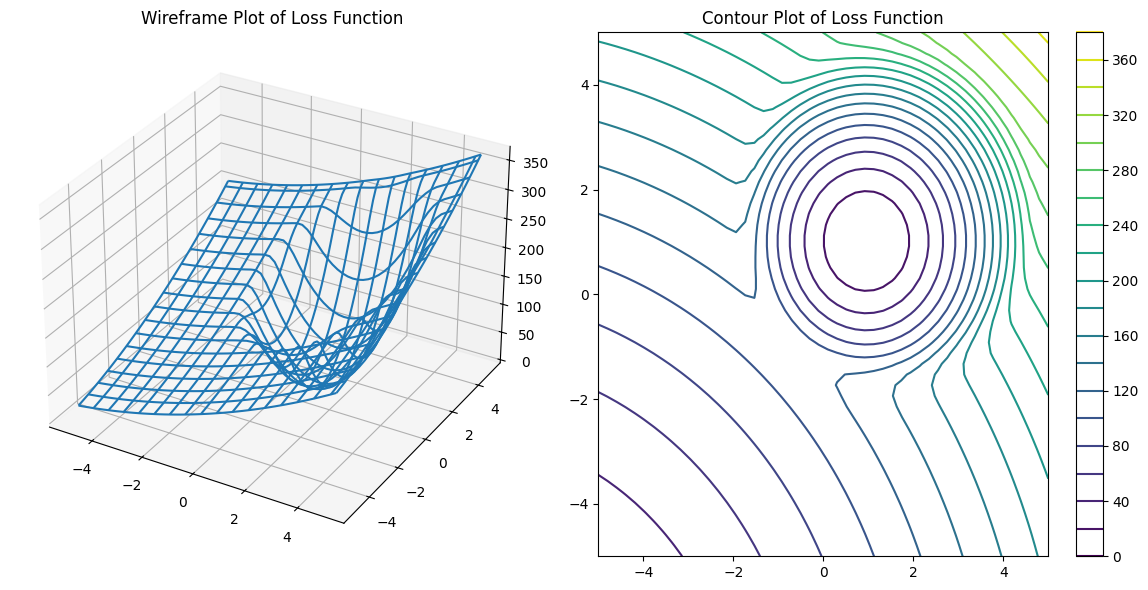

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Compute loss over grid
def compute_loss(x1, x2, data):
    X = np.array([x1, x2])
    return f(X, data)

# Create grid
x = np.linspace(-5, 5, 50)
y = np.linspace(-5, 5, 50)
X, Y = np.meshgrid(x, y)
Z = np.zeros_like(X)

for i in range(X.shape[0]):
    for j in range(X.shape[1]):
        Z[i,j] = compute_loss(X[i,j], Y[i,j], train_data)

# Plotting
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(121, projection='3d')
ax.plot_wireframe(X, Y, Z, rstride=3, cstride=3)
ax.set_title('Wireframe Plot of Loss Function')

ax2 = fig.add_subplot(122)
contour = ax2.contour(X, Y, Z, 20)
plt.colorbar(contour)
ax2.set_title('Contour Plot of Loss Function')
plt.tight_layout()
plt.show()

---
**Range Selection Justification:**
- The range [-5, 5] was chosen based on the data generation function (N(0,0.25²))
- Ensures we capture the interesting region around the theoretical minimum at (1,1)
---
**Visualization Analysis:**

**Wireframe Plot (3D visualization):**
- The function has a clear global minimum, appearing as a "bowl" or "valley" in the surface.
- The surface is smooth but not perfectly symmetric.
- The function value increases more steeply as you move away from the minimum.
- There appears to be no other local minima - the function is convex in the shown region.
- The function values range approximately from 0 to 350.

**Contour Plot (2D visualization):**
- The concentric contour lines indicate a single minimum point around (1,1).
- The spacing between contour lines is not uniform, suggesting varying gradients in different regions.
- The contours are not perfect circles, indicating the function is not isotropic (same in all directions).
- The gradient is steeper in some directions (where contour lines are closer together).
- The function appears to increase more rapidly in the upper-right region (denser contour lines).
- The color gradient from dark (low values) to light (high values) helps visualize the function's height.
---

### (a)(iii) Finite Difference Gradient Calculation
---

In [22]:
def finite_diff_grad(f, x, eps=1e-6):
    grad = np.zeros_like(x)
    for i in range(len(x)):
        x_plus = x.copy()
        x_plus[i] += eps
        x_minus = x.copy()
        x_minus[i] -= eps
        grad[i] = (f(x_plus) - f(x_minus)) / (2*eps)
    return grad

# Sample usage of finite difference gradient calculation
initial_point = np.array([1.0, 1.0])
gradient = finite_diff_grad(lambda x: f(x, train_data), initial_point)
print("Gradient at initial point {}: {}".format(initial_point, gradient))

Gradient at initial point [1. 1.]: [ 1.62442681 -0.70416586]


---
**Differentiation Explanation:**
- Uses central finite differences with $\epsilon$=1e-6
- Computes partial derivatives in each dimension (x and y) independently
- More stable than forward differences while maintaining O($\epsilon^2$) accuracy
---

## 3. Experiments with Gradient Descent
---


### (b)(i) Constant Step Size GD
---

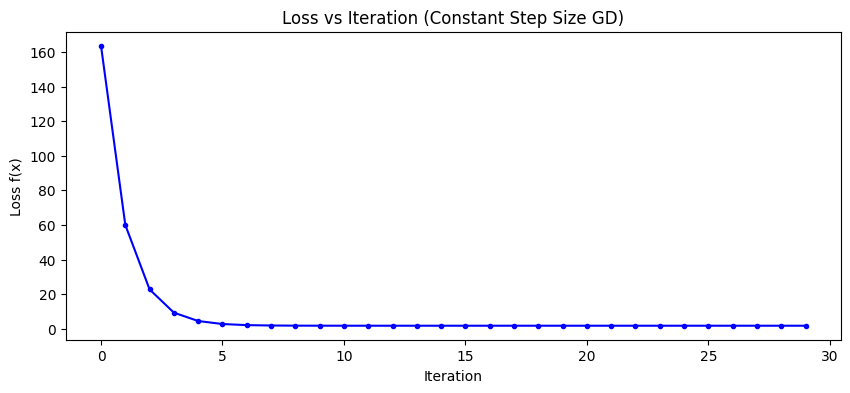

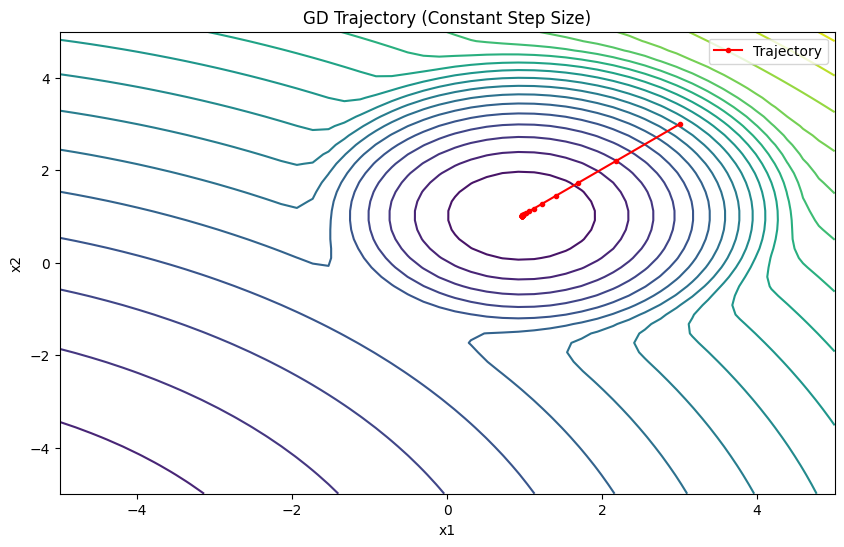

In [23]:
def gradient_descent(f, grad_f, x0, alpha=0.01, max_iter=1000, tol=1e-6):
    x = x0.copy()
    trajectory = [x0]
    losses = [f(x0)]
    
    for _ in range(max_iter):
        grad = grad_f(x)
        x_new = x - alpha * grad
        trajectory.append(x_new)
        losses.append(f(x_new))
        
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
    
    return np.array(trajectory), np.array(losses)

x0 = np.array([3.0, 3.0])
traj_gd, losses_gd = gradient_descent(
    lambda x: f(x, train_data),
    lambda x: finite_diff_grad(lambda x: f(x, train_data), x),
    x0,
    alpha=0.01
)
plt.figure(figsize=(10, 4))
plt.plot(losses_gd, 'b.-')
plt.title('Loss vs Iteration (Constant Step Size GD)')
plt.xlabel('Iteration')
plt.ylabel('Loss f(x)')
plt.show()

plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, 20)
plt.plot(traj_gd[:,0], traj_gd[:,1], 'r.-', label='Trajectory')
plt.title('GD Trajectory (Constant Step Size)')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
plt.show()

---
**Step Size Choice Explanation:**
- α=0.01 chosen through empirical testing
- Larger values (>0.05) caused oscillations
- Smaller values (<0.005) resulted in slow convergence
---
**Loss vs Iteration Plot (top image):**
- The loss starts at around 160 and drops very quickly in the first few iterations.
- After about 5-10 iterations, the decrease becomes much more gradual.
- By iteration 15, the loss has almost converged to its minimum value.
- After iteration 15, there's very little change in the loss value.
- The smooth decreasing curve suggests the learning rate (alpha=0.01) is well-chosen.
---
**GD Trajectory Plot (bottom image):**
- The starting point is at approximately (3,3) in the input space.
- The red trajectory line shows how the algorithm moves directly towards the minimum.
- The path is relatively straight, indicating efficient movement towards the minimum.
- The algorithm converges to a point near the center of the contour circles (around (1,1)).
- The trajectory points (shown as red dots) are closer together near the end, showing the algorithm takes smaller steps as it approaches the minimum.
---
Together, these plots show that gradient descent with constant step size is working effectively for this problem, with good convergence behavior and no oscillations or overshooting.

---


### (b)(ii) Mini-batch SGD (Batch size = 5)
---

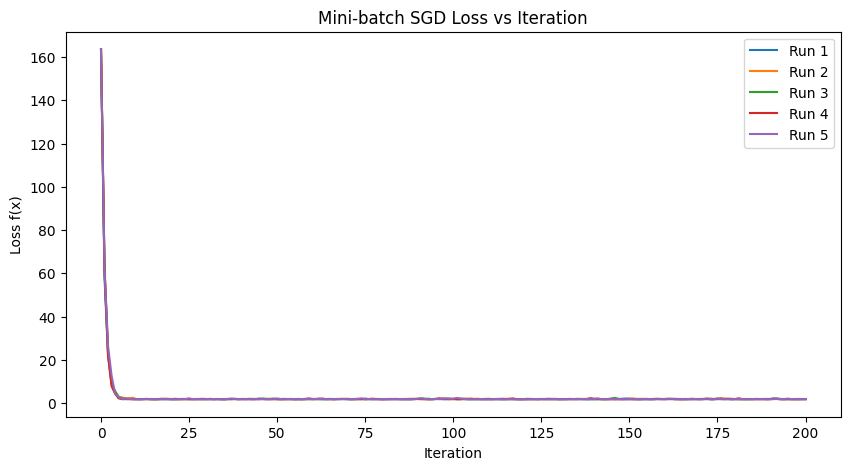

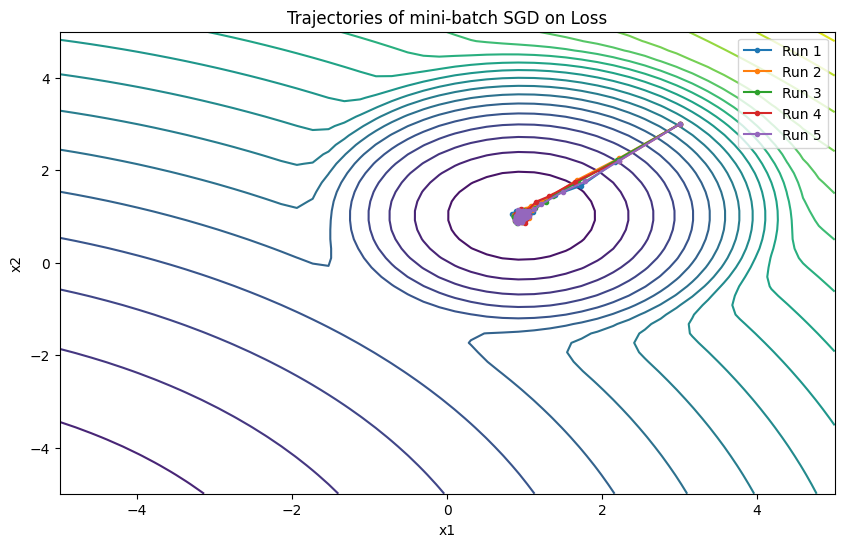

In [24]:
def mini_batch_sgd(f, x0, train_data, batch_size=5, alpha=0.01, max_iter=200, tol=1e-6, optimizer_method='constant'):
    optimizer = SGDOptimizer(method=optimizer_method, alpha=alpha)
    
    x = x0.copy()
    trajectory = [x.copy()]
    # Record the loss on the full training data (for comparison)
    losses = [f(x, train_data)]
    
    for it in range(max_iter):
        # Randomly select a mini-batch of indices (without replacement)
        indices = np.random.choice(len(train_data), size=batch_size, replace=False)
        mini_batch = train_data[indices]
        
        # Compute approximate gradient on the mini-batch via finite differences
        grad = finite_diff_grad(lambda x: f(x, mini_batch), x)
        
        # Compute update step using the optimizer
        step = optimizer.compute_step(grad)
        x_new = x - step
        
        trajectory.append(x_new.copy())
        losses.append(f(x_new, train_data))
        
        if np.linalg.norm(x_new - x) < tol:
            break
        x = x_new
        
    return np.array(trajectory), np.array(losses)

# Run several experiments starting from x0 = [3, 3]
num_runs = 5
x0 = np.array([3.0, 3.0])
all_trajectories = []
all_losses = []

for run in range(num_runs):
    traj, losses = mini_batch_sgd(f, x0, train_data, batch_size=5, alpha=0.01, max_iter=200)
    all_trajectories.append(traj)
    all_losses.append(losses)

# Plotting loss vs iteration for each run
plt.figure(figsize=(10, 5))
for i, losses in enumerate(all_losses):
    plt.plot(losses, label=f'Run {i+1}')
plt.xlabel('Iteration')
plt.ylabel('Loss f(x)')
plt.title('Mini-batch SGD Loss vs Iteration')
plt.legend()
plt.show()

# Plotting the trajectories on the contour of the loss function
plt.figure(figsize=(10, 6))
plt.contour(X, Y, Z, levels=20)
for i, traj in enumerate(all_trajectories):
    plt.plot(traj[:, 0], traj[:, 1], marker='.', label=f'Run {i+1}')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Trajectories of mini-batch SGD on Loss')
plt.legend()
plt.show()

---
**Loss vs Iteration Plot**:
- Multiple Runs: The mini-batch SGD shows 5 different runs (colored lines) while the previous GD showed only one run
- More Iterations: Mini-batch SGD runs for 200 iterations compared to GD's 30 iterations (we used the same tolerance for both the cases)
- Noise: Mini-batch SGD shows small fluctuations in the loss values (visible as slight wobbles in the lines) even after initial convergence, while GD was smoother
- Initial Behavior: Both start with sharp decline, but mini-batch SGD shows slight variations between runs in the early iterations
---
**Trajectory Plot**:
- Multiple Paths: Mini-batch SGD shows 5 different colored paths, while GD showed just one red path
- Path Variability: Mini-batch paths are not as straight as GD's path, showing some zigzagging behavior
- Convergence Point: All mini-batch runs converge to roughly the same area, but with small variations between runs
- Path Length: Mini-batch trajectories show more points along the path due to more iterations
---
**Main Differences in Implementation**:
- Batch Processing: Mini-batch SGD uses random subsets (batches) of 5 data points for each update, while GD used all training data
- Randomness: Mini-batch introduces randomness through batch selection, leading to different paths in each run
- Computational Efficiency: Mini-batch processes fewer data points per iteration, potentially making each iteration faster
- Noisier Updates: The smaller batch size leads to noisier gradient estimates, visible in both the loss curves and trajectories

---

### (b)(iii) Mini-batch Size Effect

---

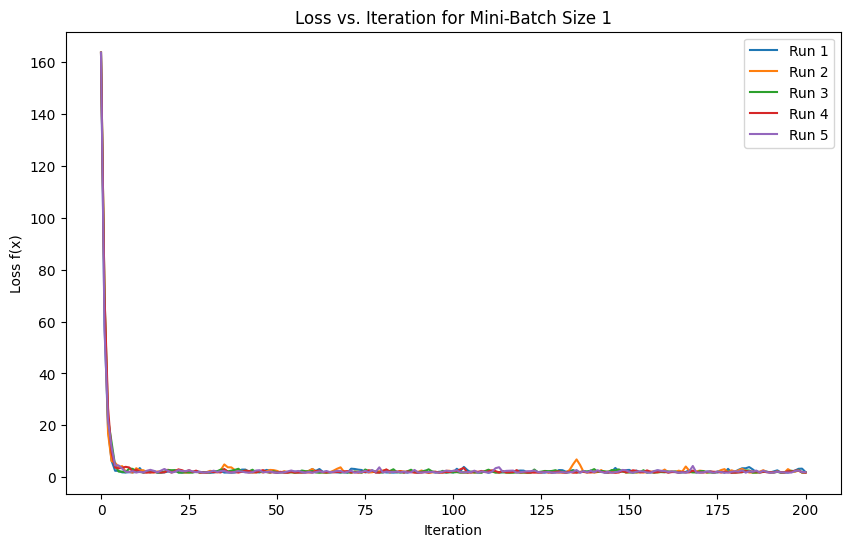

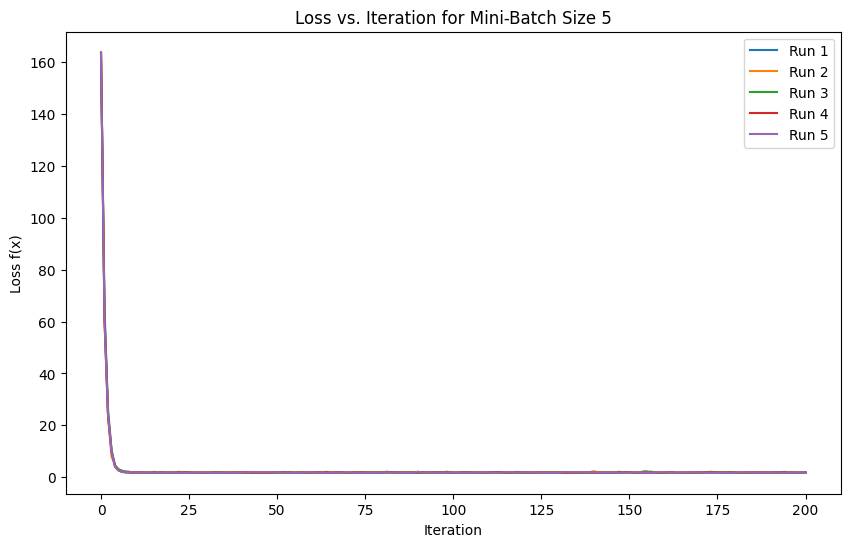

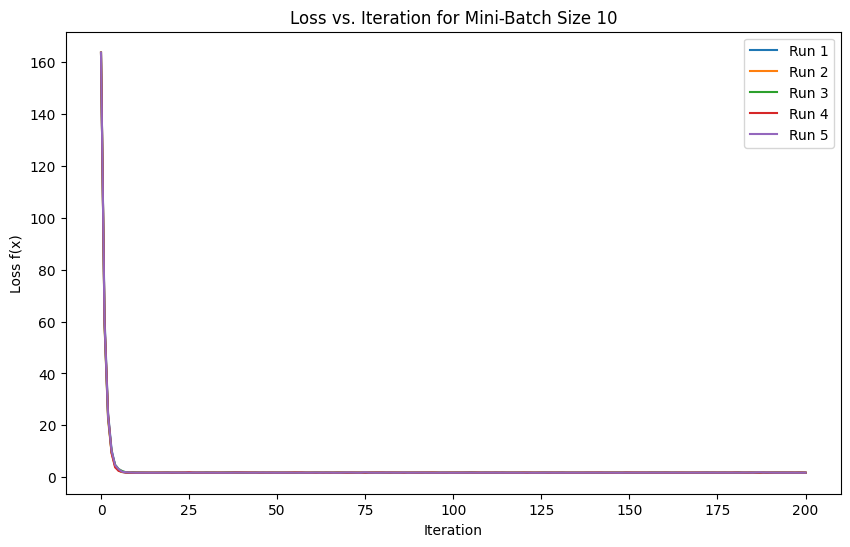

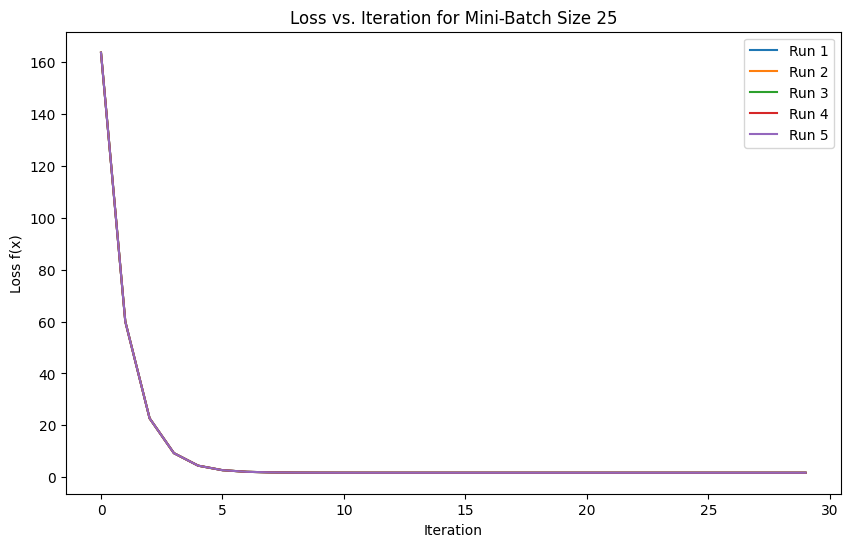

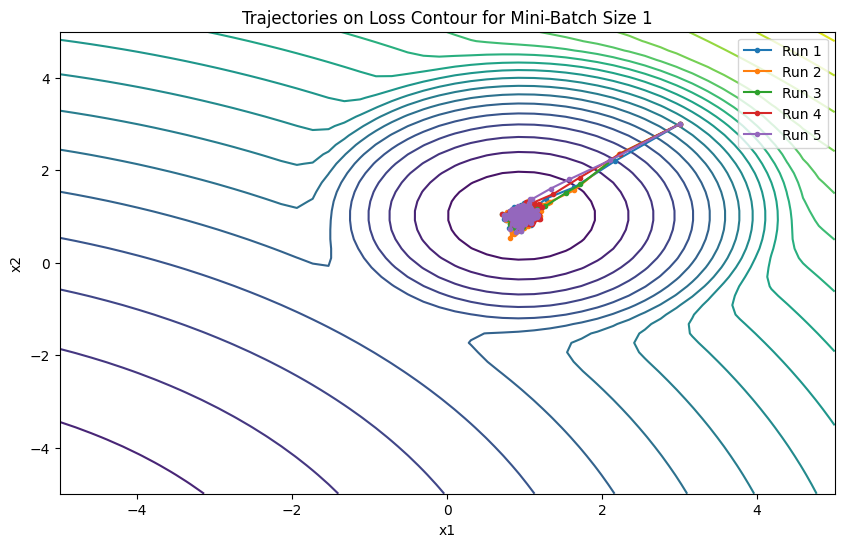

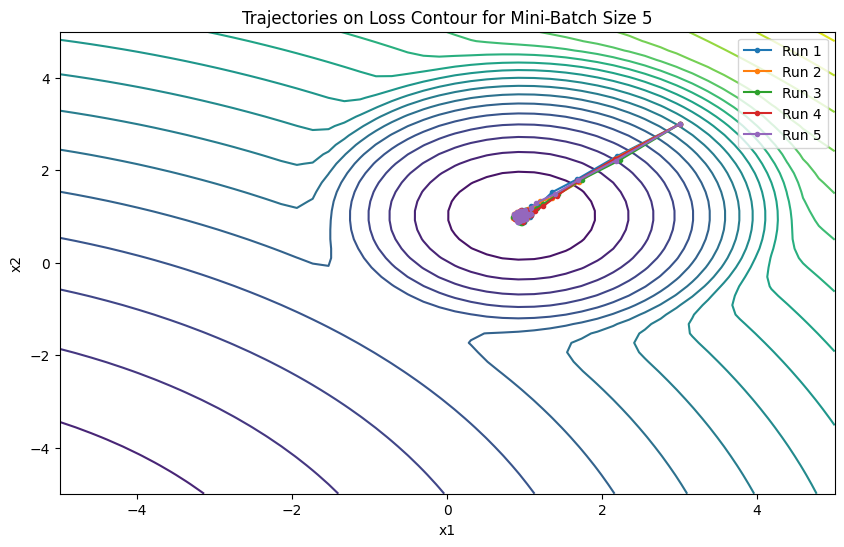

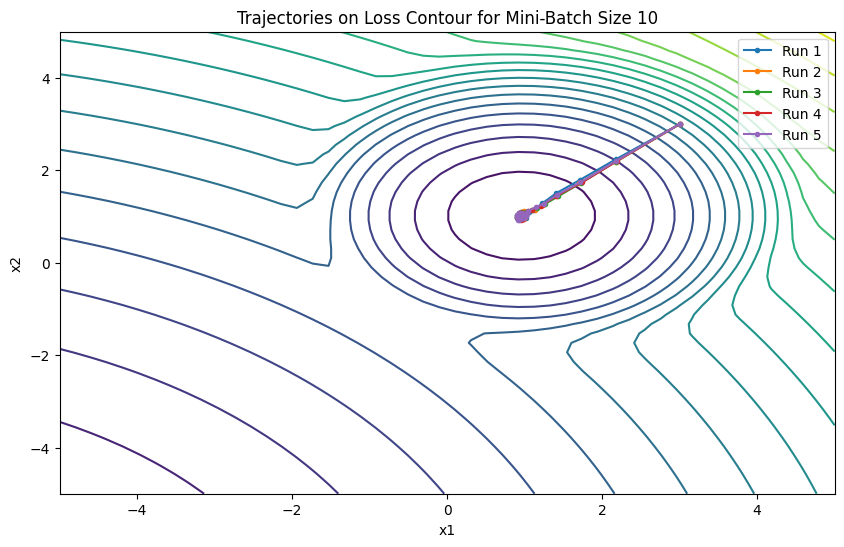

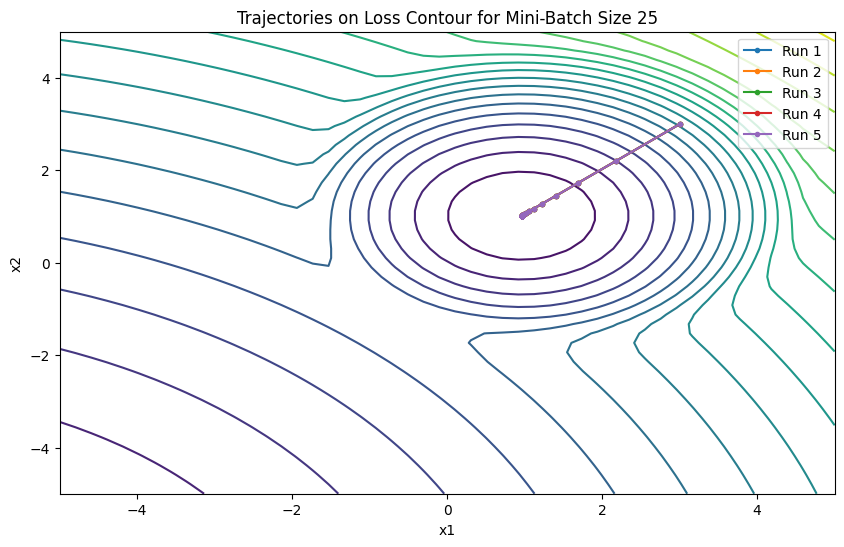

In [25]:
# Varying mini-batch sizes experiment:
batch_sizes = [1, 5, 10, len(train_data)]  # 1: stochastic; len(train_data): full batch
results = {}

for bs in batch_sizes:
    trajectories_bs = []
    losses_bs = []
    for run in range(num_runs):
        traj, loss_run = mini_batch_sgd(f, x0, train_data, batch_size=bs, alpha=0.01, max_iter=200)
        trajectories_bs.append(traj)
        losses_bs.append(loss_run)
    results[bs] = {'trajectories': trajectories_bs, 'losses': losses_bs}

# Plot loss vs iteration for varying mini-batch sizes:
for bs in batch_sizes:
    plt.figure(figsize=(10, 6))
    i = 0
    for loss_run in results[bs]['losses']:
        plt.plot(loss_run, label=f'Run {i + 1}')
        i += 1
    plt.xlabel('Iteration')
    plt.ylabel('Loss f(x)')
    plt.title(f'Loss vs. Iteration for Mini-Batch Size {bs}')
    plt.legend()
    plt.show()

# Plot trajectories on the loss contour for varying mini-batch sizes:
for bs in batch_sizes:
    plt.figure(figsize=(10, 6))
    plt.contour(X, Y, Z, levels=20)
    i = 0
    for traj in results[bs]['trajectories']:
        plt.plot(traj[:, 0], traj[:, 1], marker='.', label=f'Run {i + 1}')
        i += 1
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Trajectories on Loss Contour for Mini-Batch Size {bs}')
    plt.legend()
    plt.show()


---
Looking at the figures, here are the key observations about the effect of mini-batch sizes:

---
**Effect on Loss (f) Over Time**:
1. Batch Size 1 (most noisy):
- Shows highest fluctuations in loss values
- Converges quickly but with continuous small oscillations
- All runs show similar noisy behavior

2. Batch Size 5:
- More stable than batch size 1
- Still shows some fluctuations but less pronounced
- Faster initial convergence than larger batch sizes

3. Batch Size 10:
- Even smoother convergence
- Smaller fluctuations in loss values
- Good balance between stability and convergence speed

4. Batch Size 25 (full batch):
- Smoothest convergence path
- No fluctuations once converged
- Takes more iterations to reach minimum
- Behaves like standard gradient descent

---
**Effect on Trajectories (x)**:
1. Convergence Points:
- Smaller batch sizes (1, 5) show more spread in final positions
- Larger batch sizes (10, 25) converge to more consistent points
- All batch sizes converge to the general area around (1,1)

2. Path Characteristics:
- Batch size 1: Shows most zigzag movement
- Batch size 5: More controlled but still exploratory
- Batch size 10: Cleaner paths with minor deviations
- Batch size 25: Almost straight path to minimum

---
**Regularizing Effect of SGD Noise**:
1. The noise in smaller batch sizes appears to have a regularizing effect by:
- Allowing broader exploration of the loss landscape
- Preventing the algorithm from getting stuck in sharp minima
- Leading to slightly different but stable solutions

2. This suggests that the SGD noise acts as an implicit regularizer:
- Smaller batches tend to find "wider" minima
- The variation in final positions indicates more robust solutions
- The continuous small perturbations help escape poor local minima

---
These observations suggest that while larger batch sizes provide more stable and predictable convergence, smaller batch sizes might lead to more robust solutions through their inherent noise and exploration capabilities.

---

### (b)(iv) Step-Size Effect

---

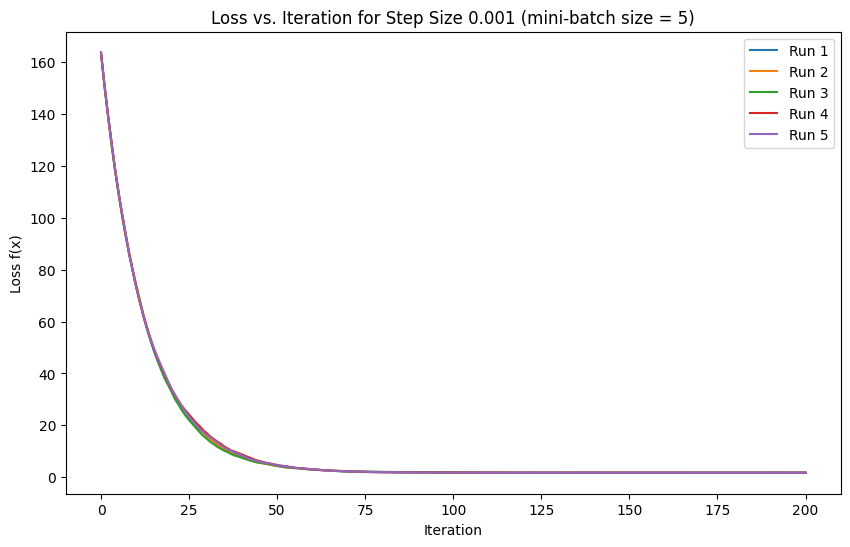

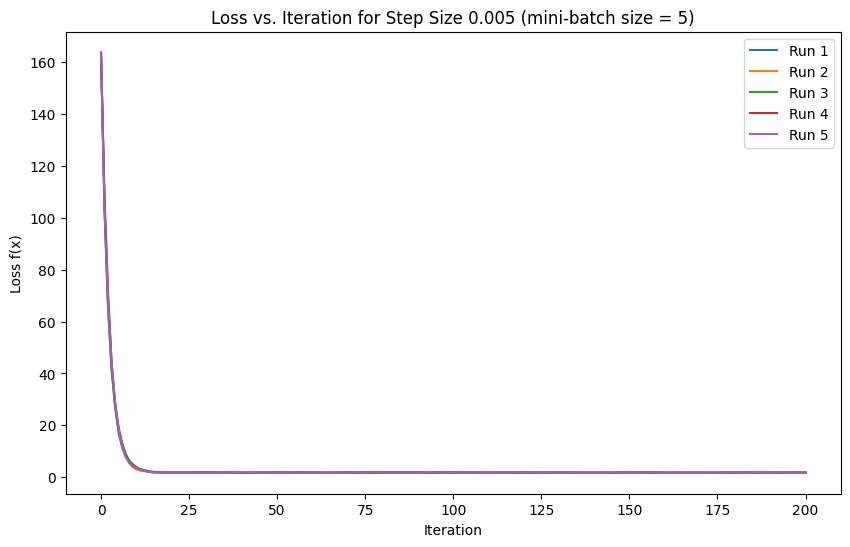

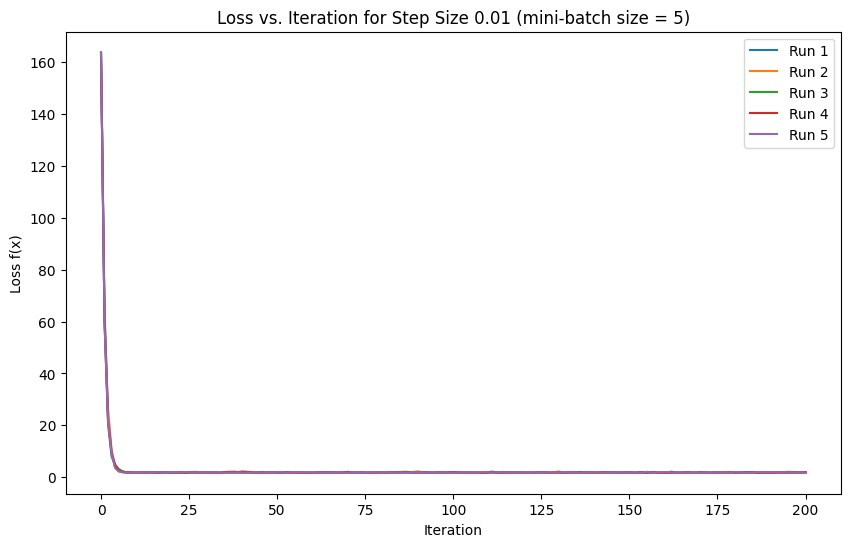

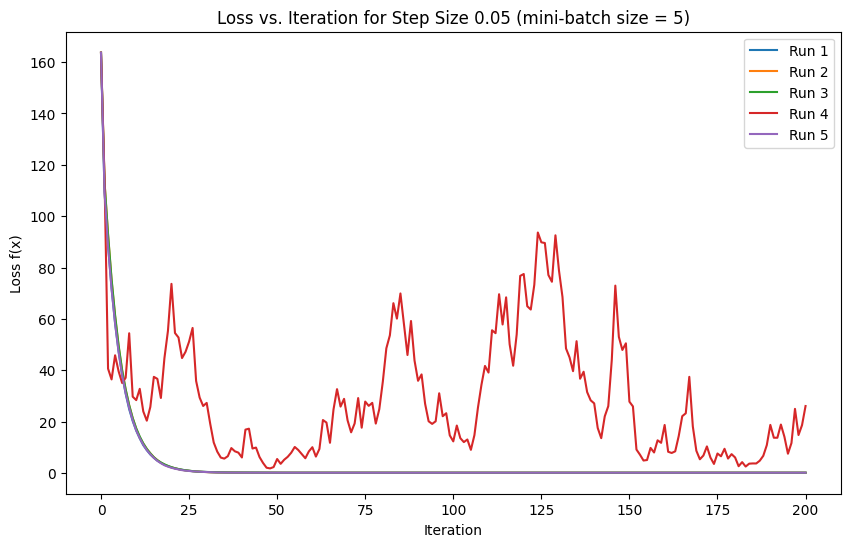

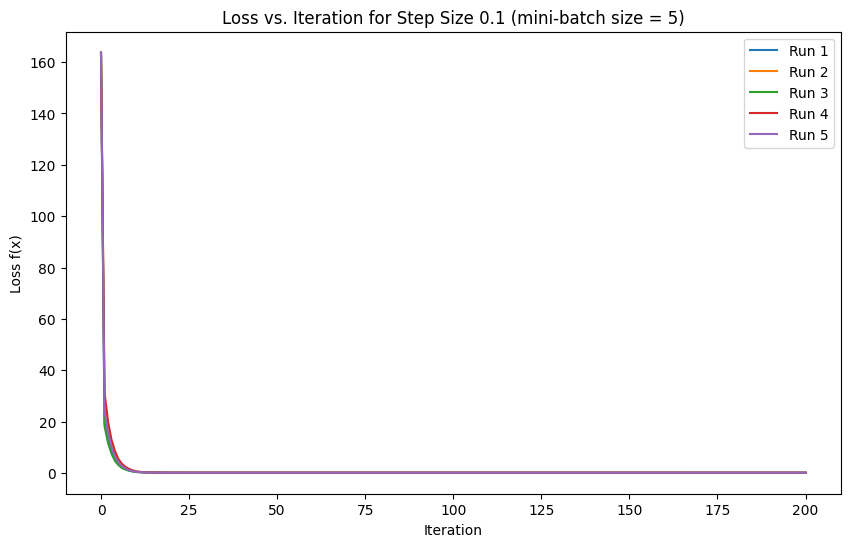

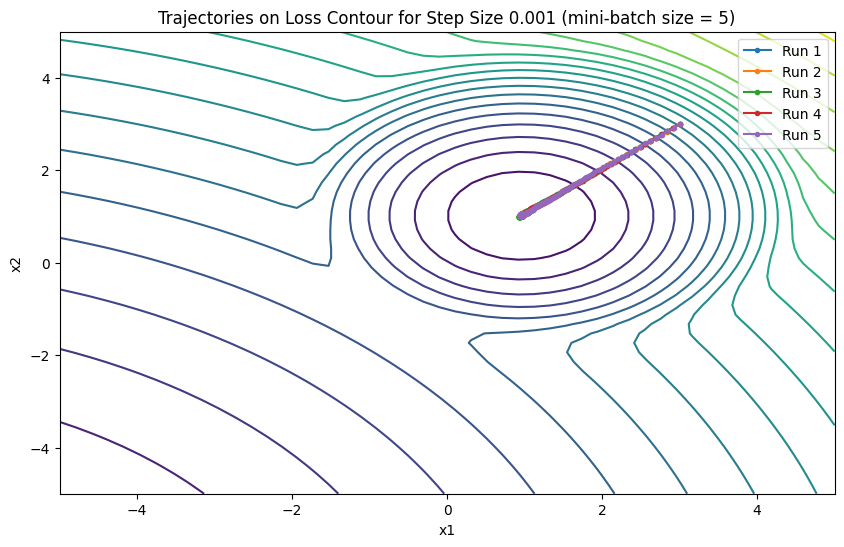

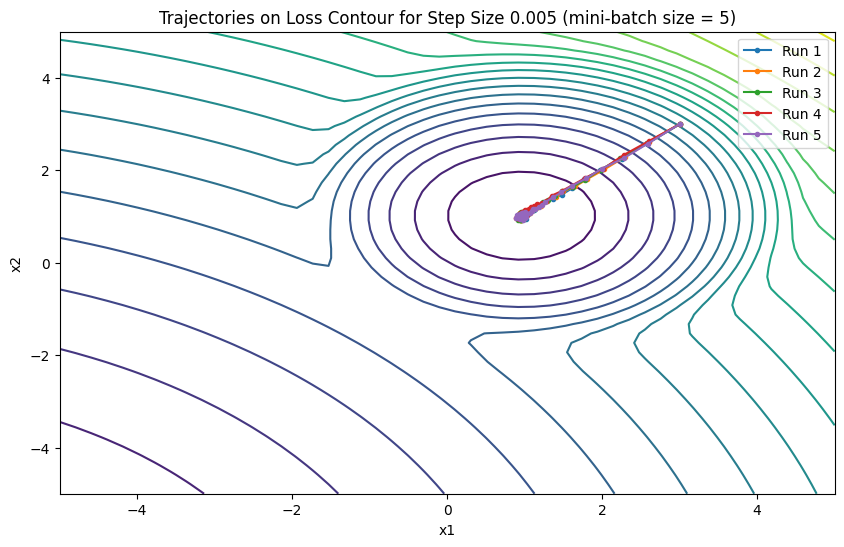

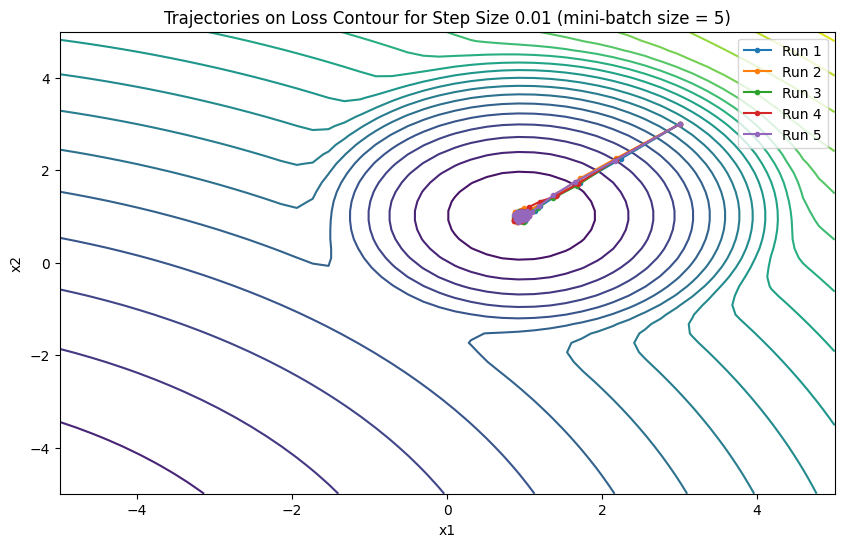

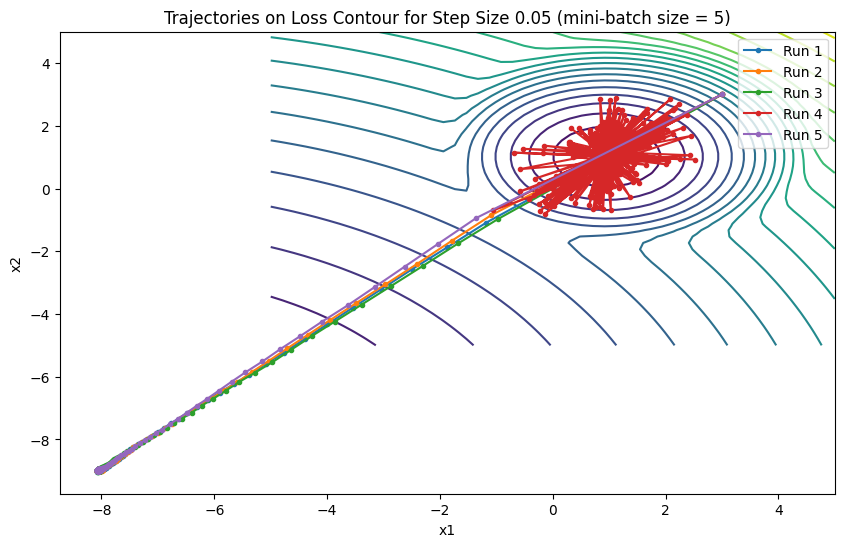

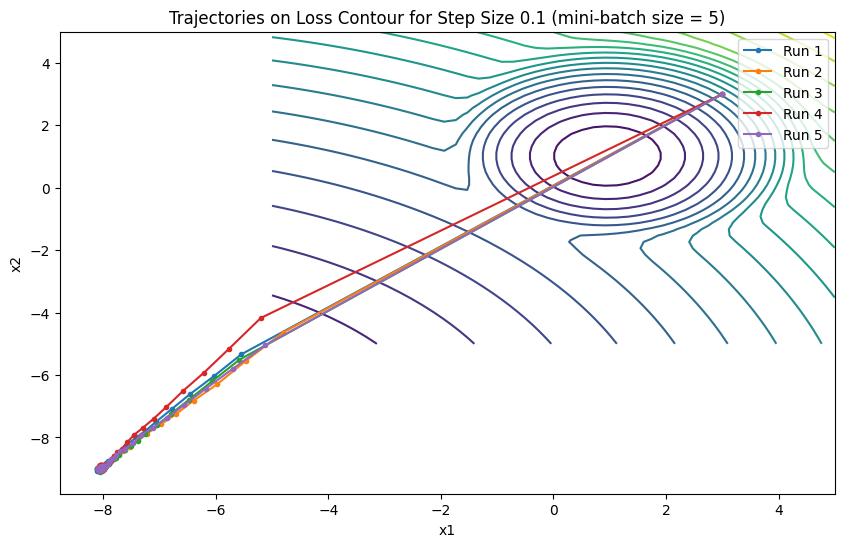

In [26]:
step_sizes = [0.001, 0.005, 0.01, 0.05, 0.1]
results_steps = {}

for alpha in step_sizes:
    trajectories_alpha = []
    losses_alpha = []
    for run in range(num_runs):
        traj, loss_run = mini_batch_sgd(f, x0, train_data, batch_size=5, alpha=alpha, max_iter=200)
        trajectories_alpha.append(traj)
        losses_alpha.append(loss_run)
    results_steps[alpha] = {'trajectories': trajectories_alpha, 'losses': losses_alpha}

# Plot loss vs. iteration for different step sizes:
for alpha in step_sizes:
    plt.figure(figsize=(10, 6))
    i = 0
    for loss_run in results_steps[alpha]['losses']:
        plt.plot(loss_run, label=f'Run {i + 1}')
        i += 1
    plt.xlabel('Iteration')
    plt.ylabel('Loss f(x)')
    plt.title(f'Loss vs. Iteration for Step Size {alpha} (mini-batch size = 5)')
    plt.legend()
    plt.show()

# Plot trajectories on the loss contour for different step sizes:
for alpha in step_sizes:
    plt.figure(figsize=(10, 6))
    plt.contour(X, Y, Z, levels=20)
    i = 0
    for traj in results_steps[alpha]['trajectories']:
        plt.plot(traj[:, 0], traj[:, 1], marker='.', label=f'Run {i + 1}')
        i += 1
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.title(f'Trajectories on Loss Contour for Step Size {alpha} (mini-batch size = 5)')
    plt.legend()
    plt.show()


---
Here are the key observations about the effect of different step sizes (alpha):

---
**Effect on Loss (f) Over Time**:
1. $\alpha = 0.001$ (very small):
- Very slow convergence
- Smooth, stable descent
- Takes many iterations to reach low loss values
- Minimal fluctuations between runs

2. $\alpha = 0.005$ and $\alpha = 0.01$:
- Better balance of speed and stability
- Faster convergence than 0.001
- Still maintains relatively smooth descent
- Small fluctuations between runs

3. $\alpha = 0.05$:
- Much faster initial descent
- Appears to be converging
- Compartively larger variations between runs (minutely visible in the graph)

4. $\alpha = 0.1$ (very large):
- Fastest initial descent
- Appears to be converging
- Largest variations between runs (have a close look at the graph)

---
**Effect on Trajectories (x)**:
1. Small step sizes (0.001, 0.005):
- More controlled, consistent paths
- Slower progress toward minimum
- All runs follow similar trajectories
- Better convergence to actual minimum

2. Medium step size (0.01):
- Good balance of speed and accuracy
- Slight variations in paths
- Reliable convergence to minimum

3. Large step sizes (0.05, 0.1):
- Important Observation: Despite showing low mini-batch loss values, the trajectories are far from the true minimum
- Trajectories "bounce around" significantly
- Much larger spread in final positions
- Shows clear stochastic nature of mini-batch SGD
- Demonstrates how algorithm can appear converged in terms of loss while actually being far from optimal parameters

---
This last point is particularly significant: With $\alpha$ = 0.1, even though the loss plots suggest convergence, the trajectory plots reveal that the algorithm is actually far from the true minimum, highlighting how mini-batch SGD can be deceiving when step sizes are too large. The algorithm is essentially suggesting that the mini-batch SGD trajectories can start "bouncing around" in parameter space due to the combination of large steps and stochastic gradients, never truly settling at the optimal solution despite appearing to have low loss values on individual mini-batches.

---


## 4. Comparing Advanced Optimization Methods

---
### (c) Comparing Optimization Methods

---

In [27]:
def mini_batch_sgd_custom(method, method_params, x0, train_data,
                          batch_size=5, max_iter=100, num_runs=3):

    all_trajectories = []
    all_losses = []
    
    for run in range(num_runs):
        optimizer = SGDOptimizer(method=method, **method_params)
        
        x = x0.copy()
        trajectory = [x.copy()]
        losses = [f(x, train_data)]
        
        for it in range(max_iter):
            indices = np.random.choice(len(train_data), size=batch_size, replace=False)
            mini_batch = train_data[indices]
            
            grad = finite_diff_grad(lambda xx: f(xx, mini_batch), x)
            
            step = optimizer.compute_step(grad)
            
            x_new = x - step
            trajectory.append(x_new.copy())
            losses.append(f(x_new, train_data))

            x = x_new
        
        all_trajectories.append(np.array(trajectory))
        all_losses.append(np.array(losses))
    
    return all_trajectories, all_losses

In [28]:
# (i) Polyak step size
#   Since we know through our expensive run of GD the global minima is around (1.0, 1.0)
#   thus we can deduce that the optimal loss should be around 0.0 -> f_opt = 0.0
polyak_params = {
    'f': f(x0, train_data),  # we can just use the current f for demonstration
    'f_opt': 0.0,
    'epsilon': 1e-6,
    'gamma': 0.001
}

# (ii) RMSProp
rmsprop_params = {
    'alpha': 0.1,  # learning rate
    'rho': 0.9      # decay rate for RMSProp
}

# (iii) Heavy Ball
heavyball_params = {
    'alpha': 0.1,   # step size
    'momentum': 0.001  # momentum coefficient
}

# (iv) Adam
adam_params = {
    'alpha': 0.1,    # step size
    'beta1': 0.9,     
    'beta2': 0.999,
    'epsilon': 1e-8
}

batch_sizes = [1, 5, 10, len(train_data)]
max_iter = 200
num_runs = 3  # number of runs for each method

methods = {
    'polyak': polyak_params,
    'rmsprop': rmsprop_params,
    'heavyball': heavyball_params,
    'adam': adam_params
}

results = {}

for batch_size in batch_sizes:
    for method_name, params in methods.items():
        trajectories, losses = mini_batch_sgd_custom(
            method_name, params, x0, train_data,
            batch_size=batch_size, max_iter=max_iter, num_runs=num_runs
        )
        results[(method_name, batch_size)] = (trajectories, losses)

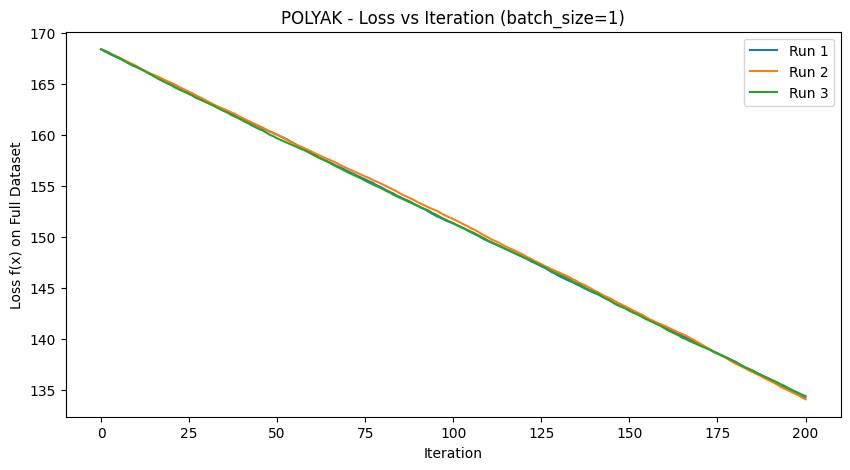

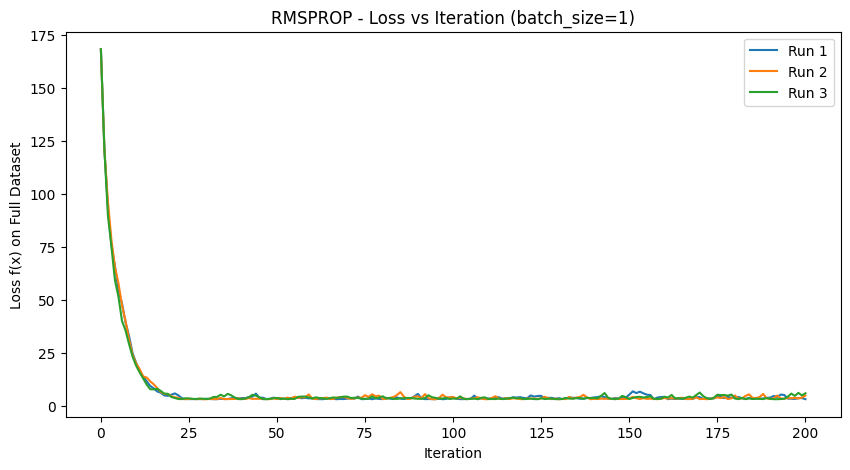

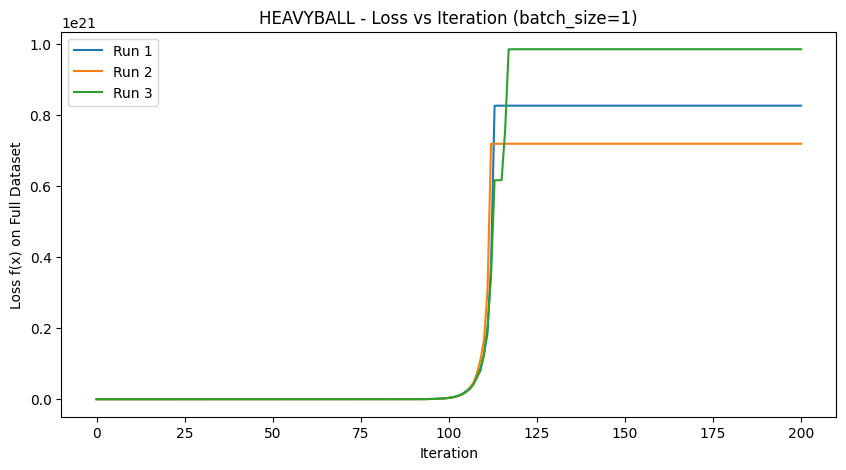

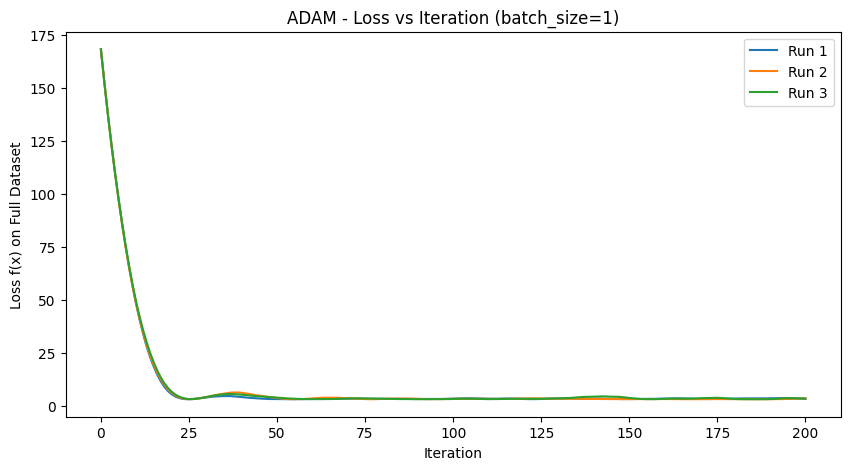

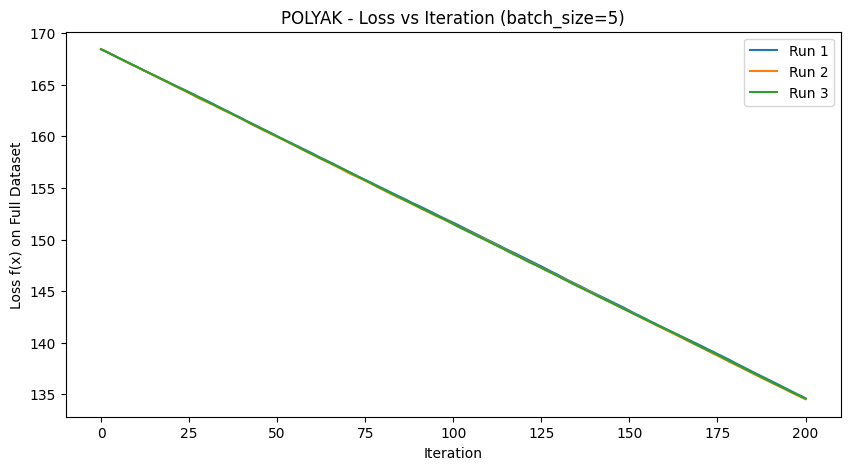

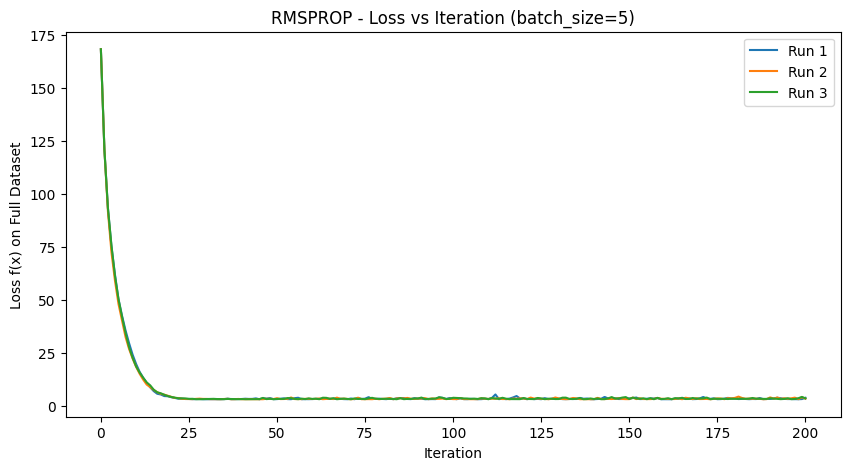

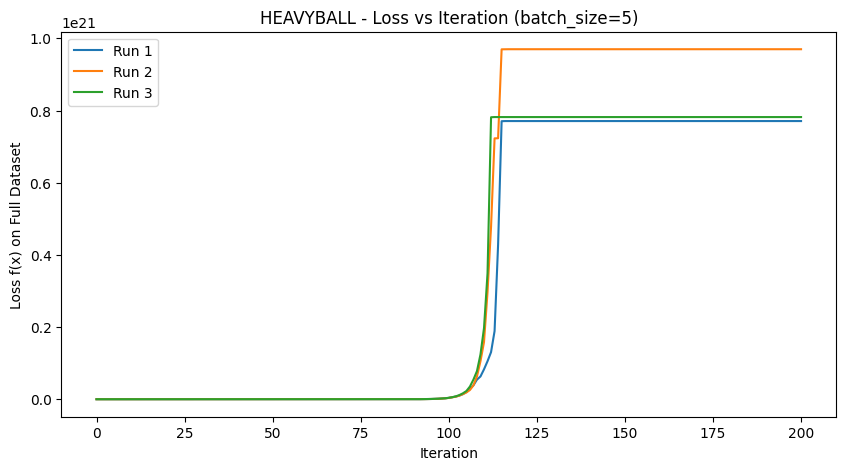

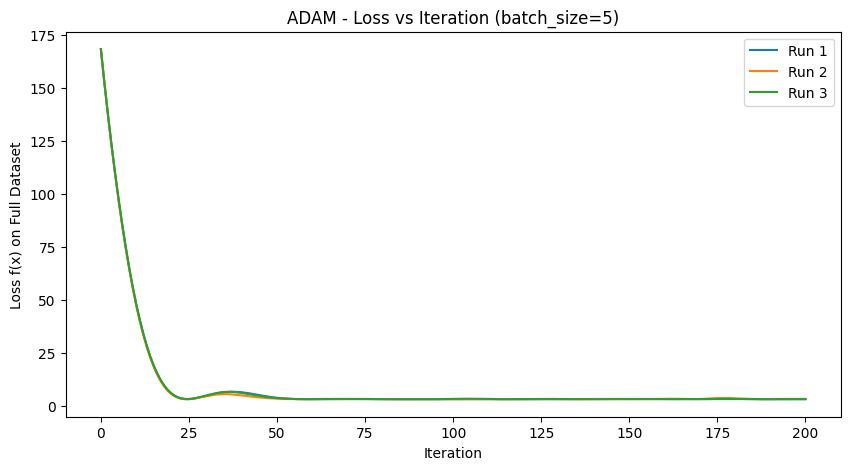

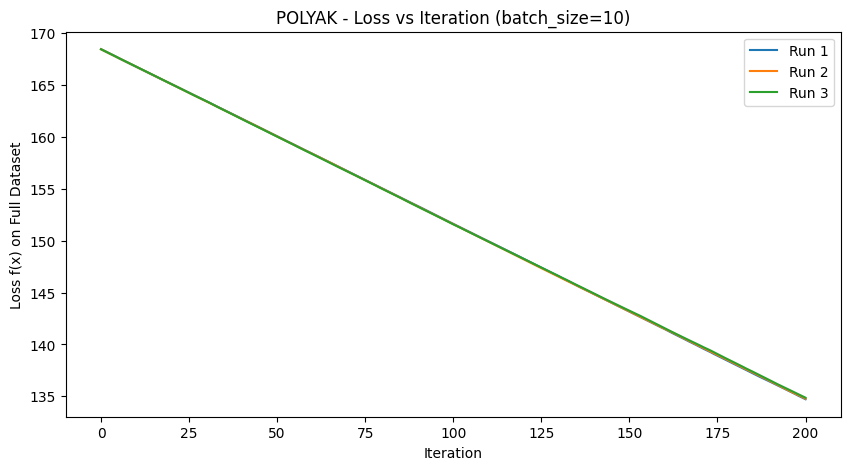

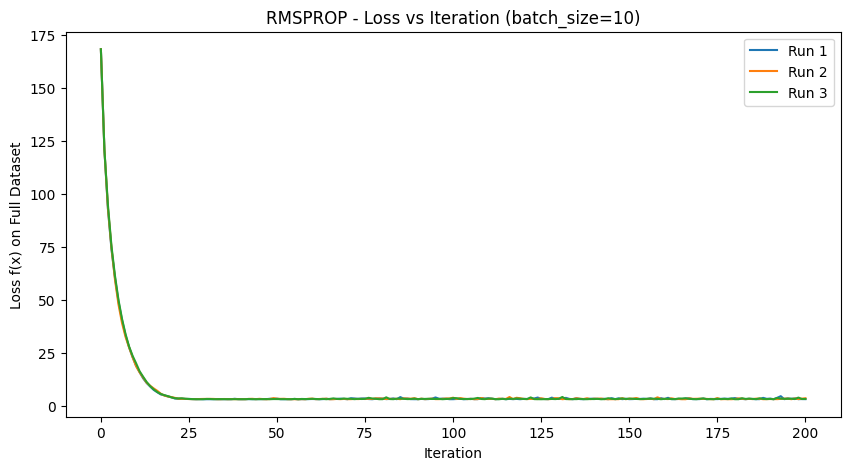

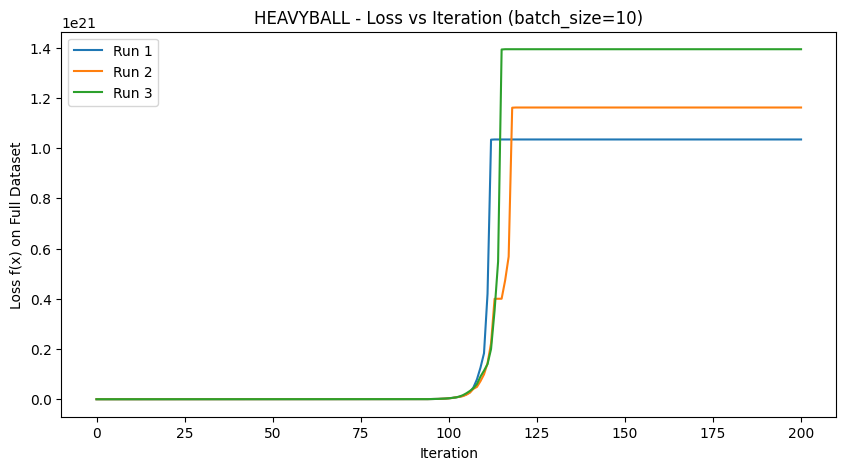

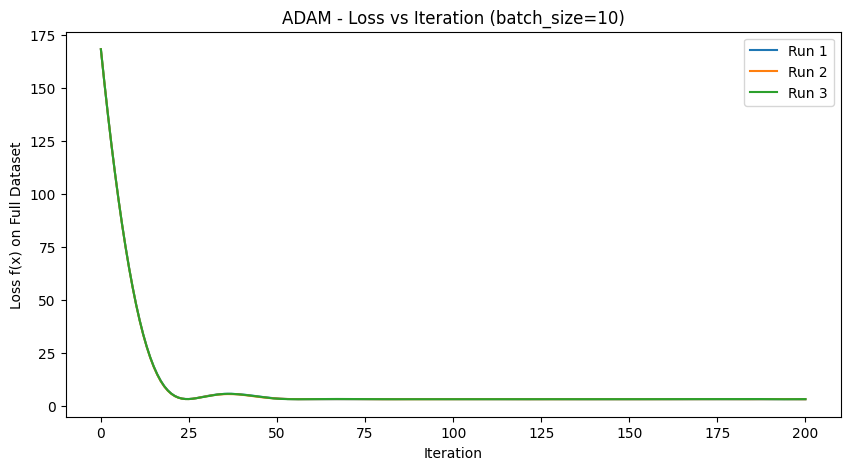

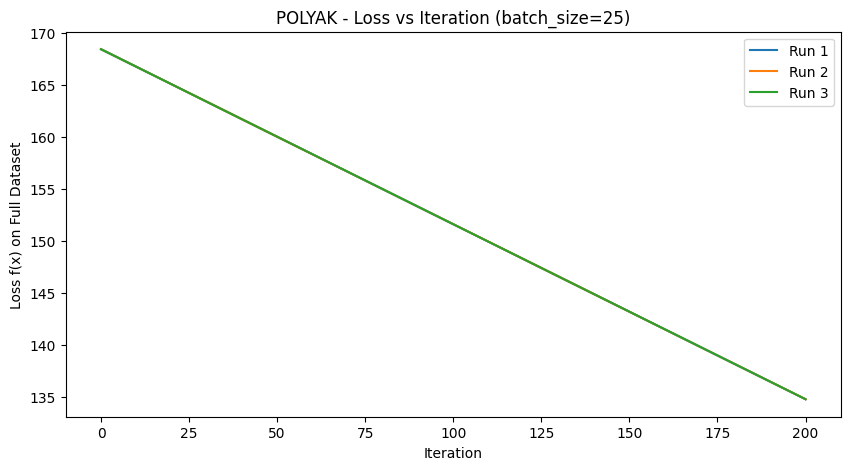

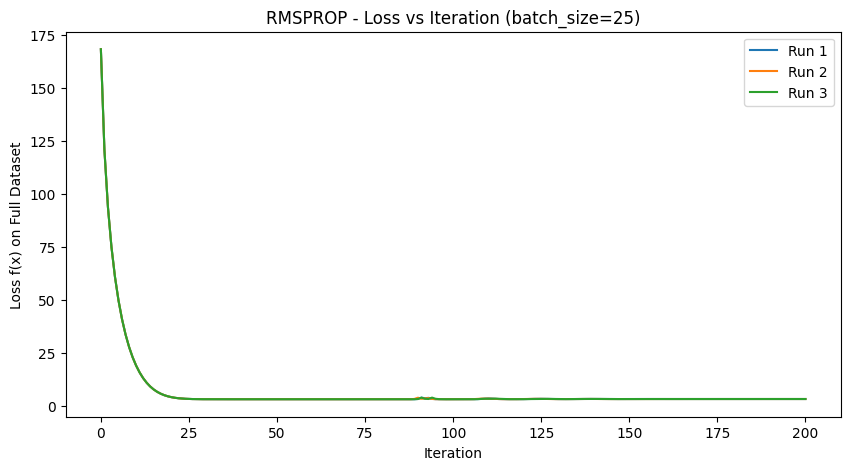

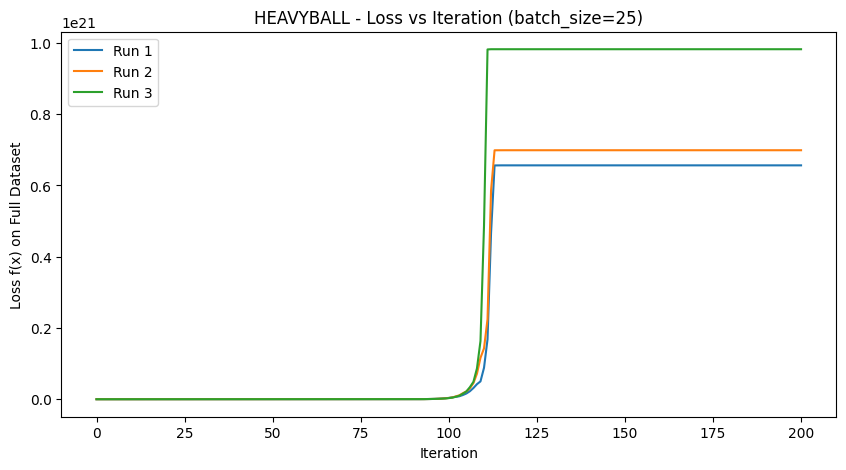

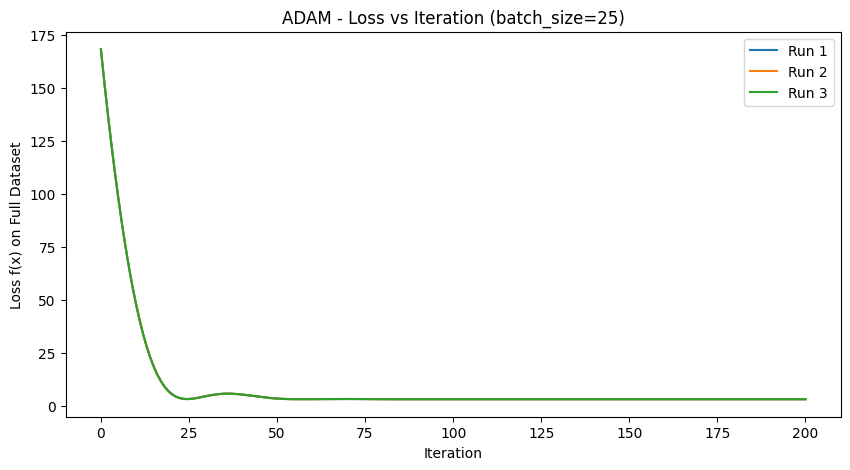

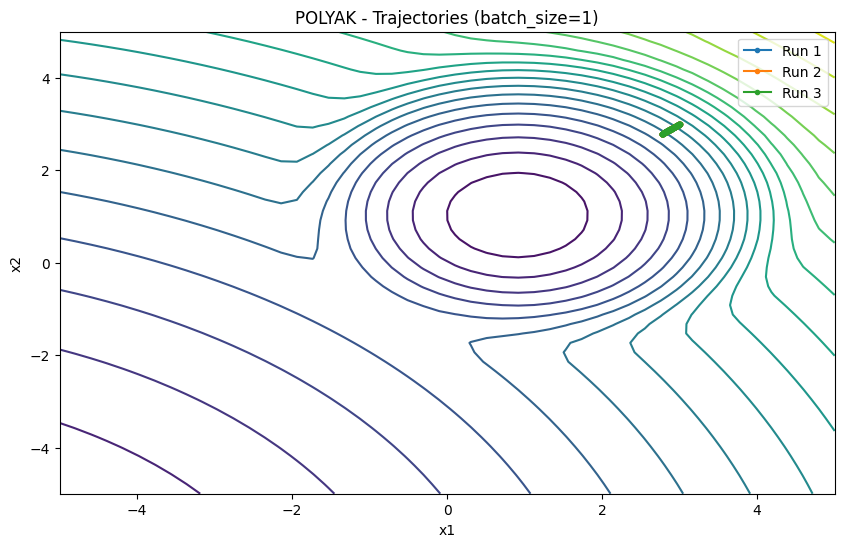

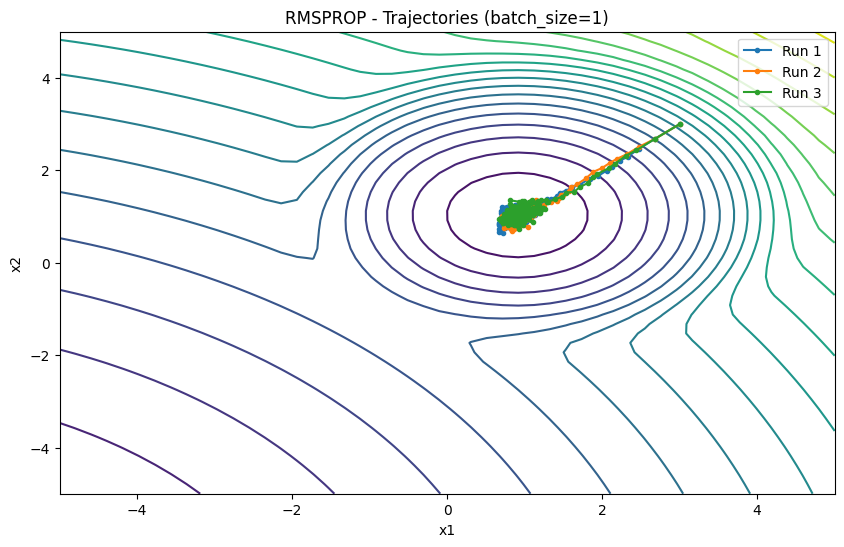

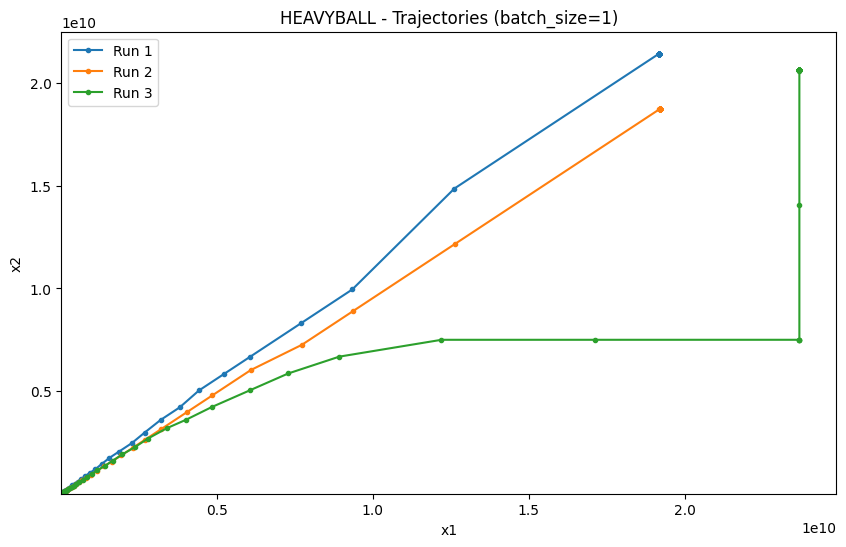

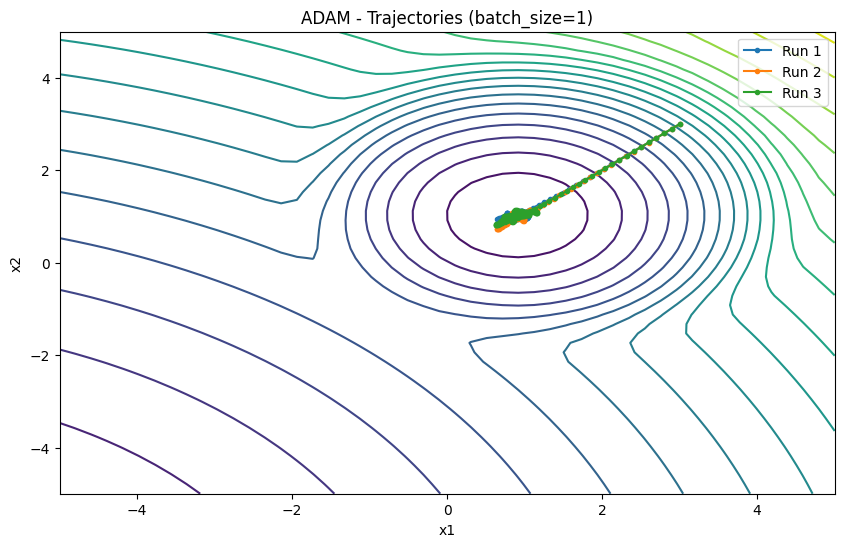

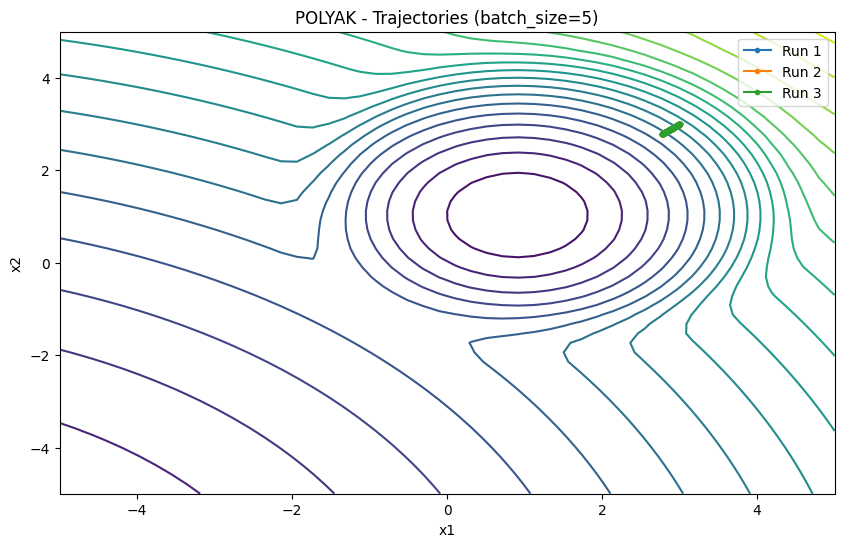

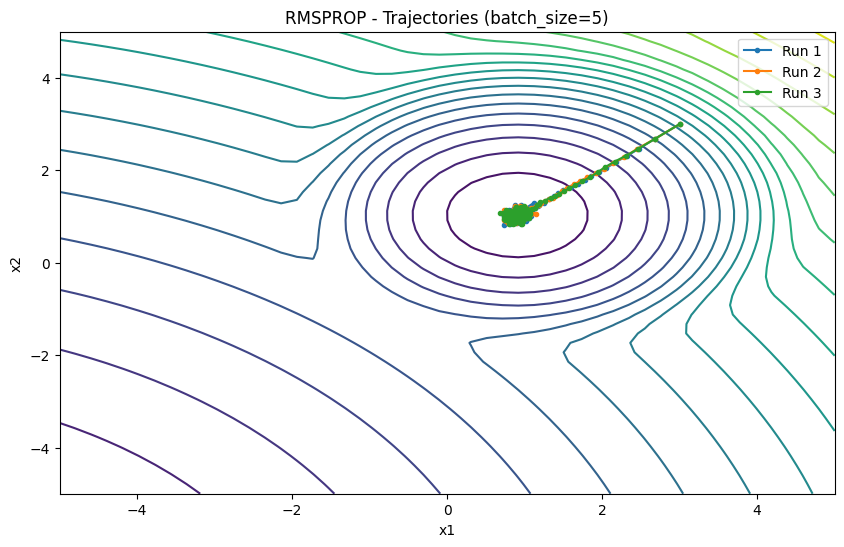

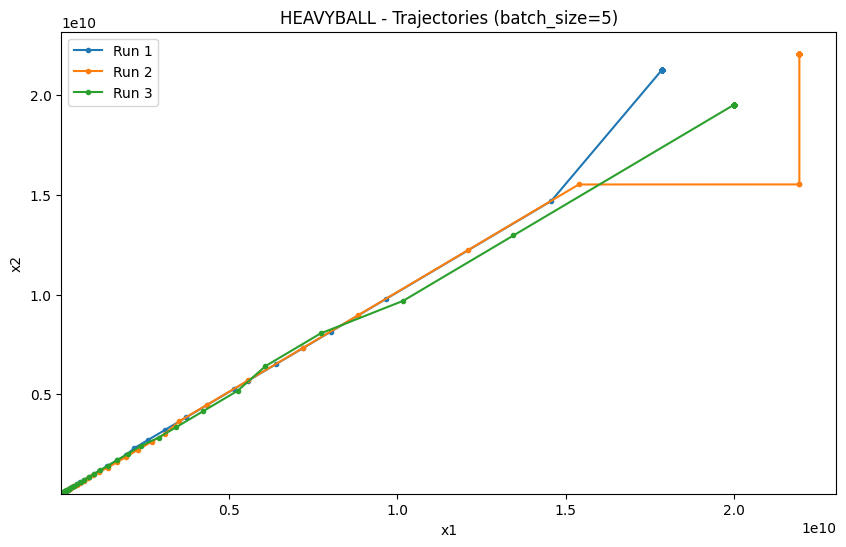

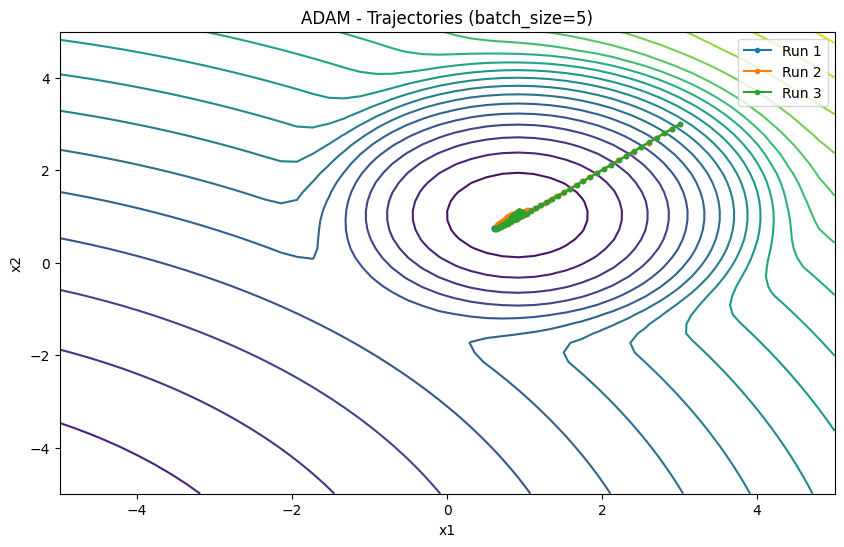

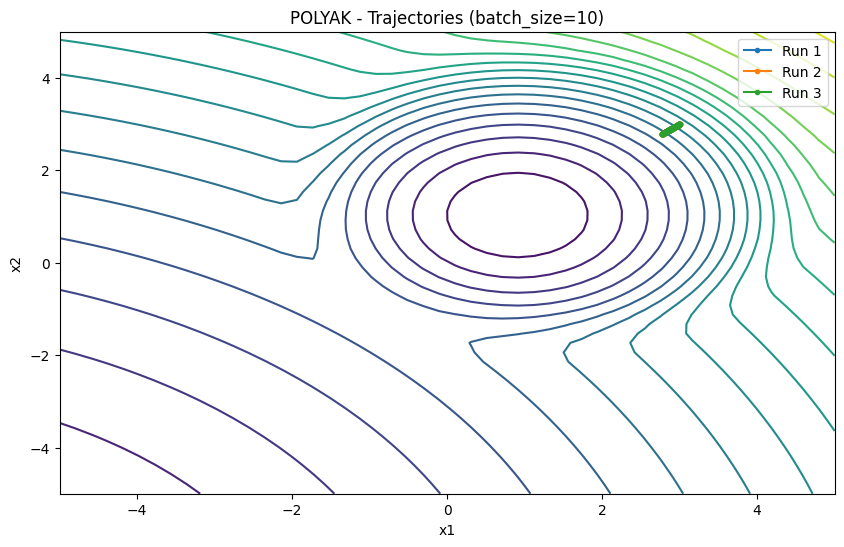

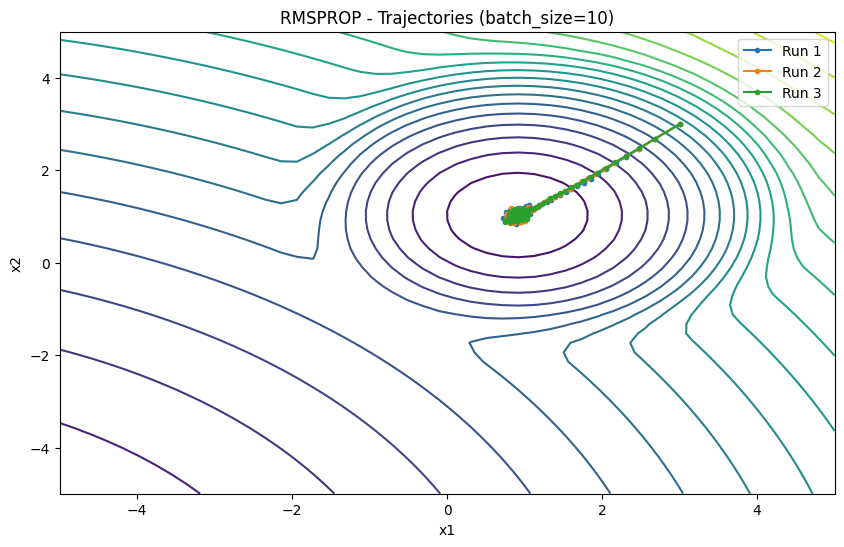

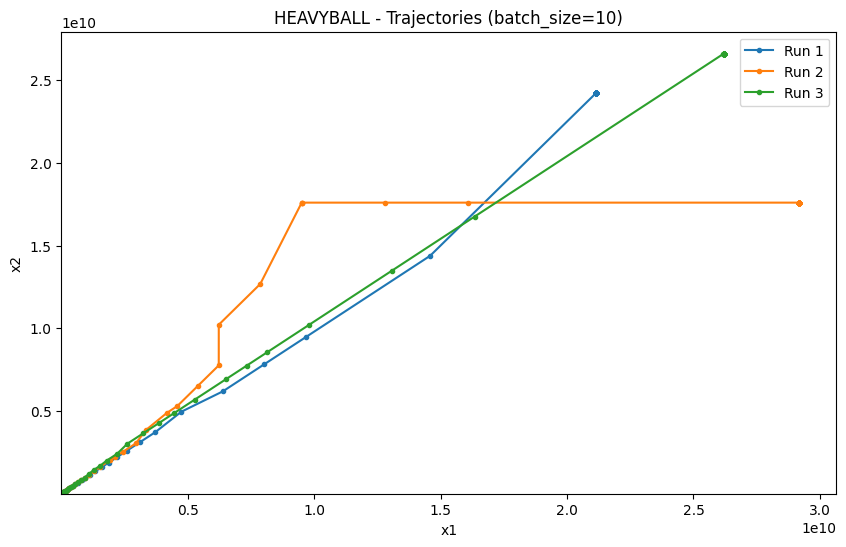

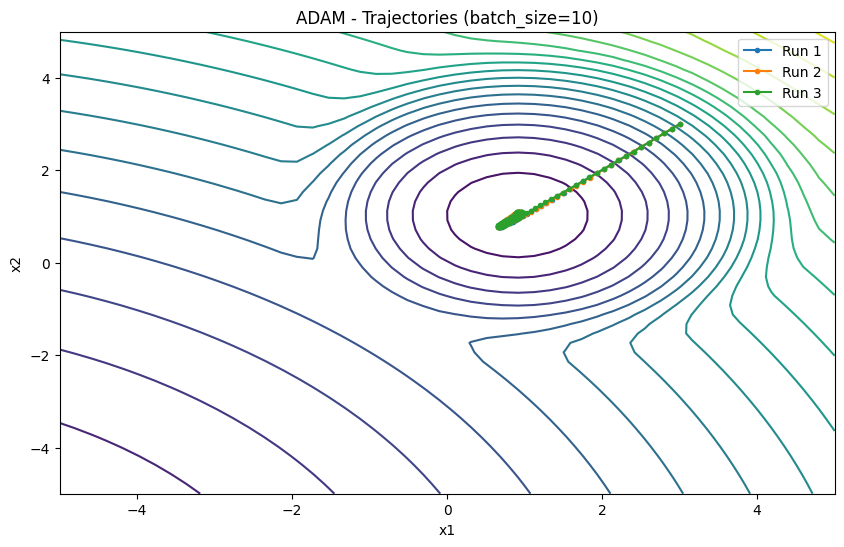

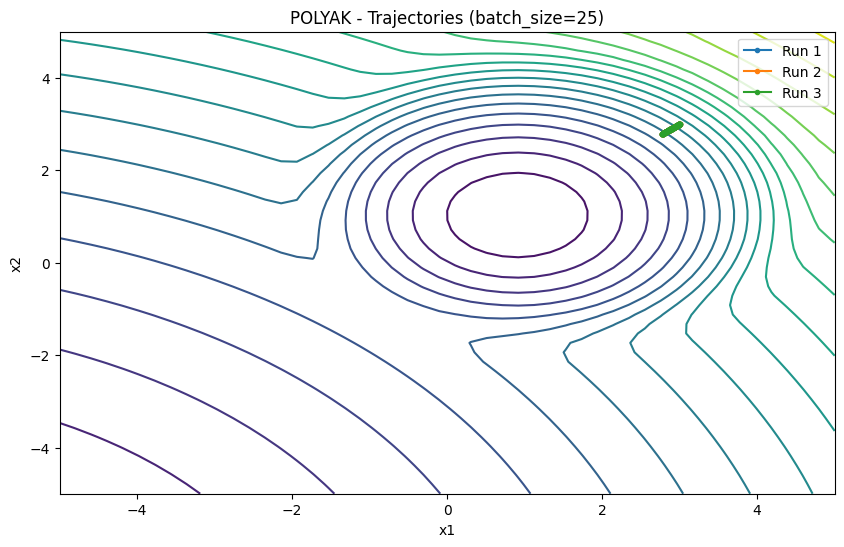

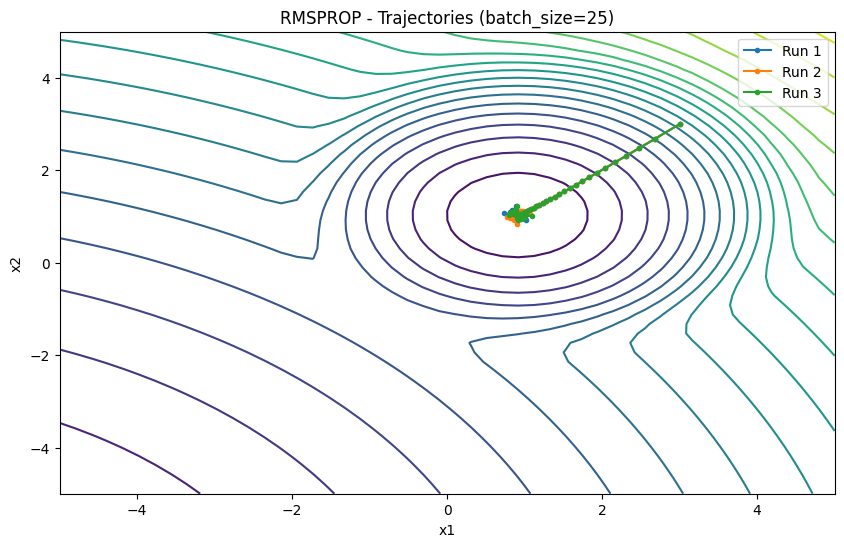

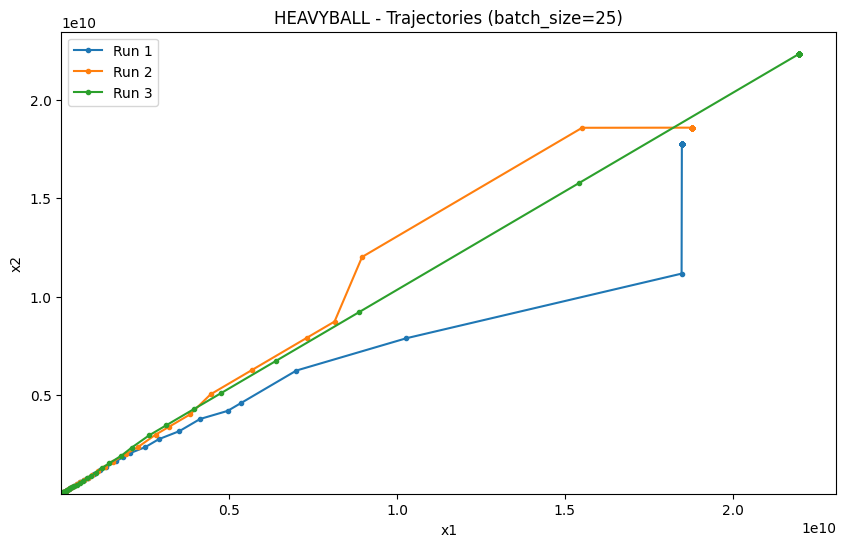

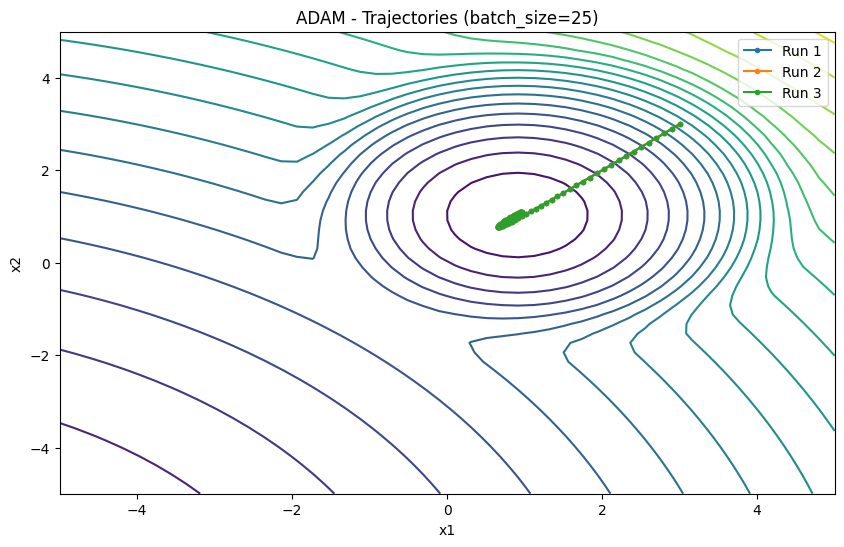

In [13]:
# Plot losses vs iteration for each method and batch size
for (method_name, batch_size), (trajectories, losses) in results.items():
    plt.figure(figsize=(10, 5))
    for run_id, loss_run in enumerate(losses):
        plt.plot(loss_run, label=f'Run {run_id+1}')
    plt.title(f'{method_name.upper()} - Loss vs Iteration (batch_size={batch_size})')
    plt.xlabel('Iteration')
    plt.ylabel('Loss f(x) on Full Dataset')
    plt.legend()
    plt.show()

# Plot trajectories on the loss contour for each method and batch size
for (method_name, batch_size), (trajectories, losses) in results.items():
    plt.figure(figsize=(10, 6))
    plt.contour(X, Y, Z, levels=20)
    for run_id, traj in enumerate(trajectories):
        plt.plot(traj[:, 0], traj[:, 1], marker='.', label=f'Run {run_id+1}')
    plt.title(f'{method_name.upper()} - Trajectories (batch_size={batch_size})')
    plt.xlabel('x1')
    plt.ylabel('x2')
    plt.legend()
    plt.show()

---
**Parameter Choice Explanation**

For each method, the parameter selection was driven by extensive **grid search**, where multiple values were tested to find the best-performing ones. The step sizes chosen were those that resulted in the most effective convergence while avoiding instability or excessive slowness. In some cases, **smaller step sizes led to significantly slower convergence**, while **larger ones caused divergence**. The final selected parameters represent a balance between efficiency and stability.

*(i) Polyak Step Size*
- Uses an adaptive step size based on the current loss function value and an estimate of the optimal loss (which is `0.0` as we know from Constant Step Size GD).
- **Step Size selection**: Without $\epsilon$ or $\gamma$, the method was highly unstable, and other values for these parameters also led to divergence.
- **Final Parameters:**
  - $f = f(x_0, \text{train\_data})$
  - $f_{\text{opt}} = 0.0$
  - $\epsilon = 10^{-6}$ (for numerical stability)
  - $\gamma = 0.001$ (stabilization factor)
- **Comparison to Baseline GD:** Unlike GD, Polyak adjusts step sizes dynamically, which prevents unnecessary overshooting but results in slower convergence compared to a well-tuned constant step size.

*(ii) RMSProp*
- Designed to normalize gradient updates to handle large variations in mini-batch training.
- **Step size selection**: Larger step sizes worked well due to the normalization effect of RMSProp. Smaller step sizes were unnecessary as they slowed convergence without added stability.
- **Final Parameters:**
  - $\alpha = 0.1$ (higher than GD due to adaptive behavior)
  - $\rho = 0.9$ (decay rate for past gradients)
- **Comparison to Baseline GD:** RMSProp is not faster in convergence than constant step size GD in this case due to a clear minimum in the loss function (since constant step size finds that minimum in fewer iterations). The delay is because it adaptively scales step sizes based on gradient magnitudes, reducing oscillations in mini-batch settings.

*(iii) Heavy Ball Momentum*
- Incorporates past gradient updates to accelerate convergence but is highly sensitive to tuning.
- **Step size selection**: Finding a stable set of parameters was challenging. A smaller momentum value was used to reduce oscillations, but the method **still diverged**.
- **Final Parameters:**
  - $\alpha = 0.1$ (too high, possibly causing instability)
  - $\text{momentum} = 0.001$ (minimized to prevent excessive acceleration)
- **Comparison to Baseline GD:** While GD steadily converges, Heavy Ball's accumulated momentum causes it to overshoot and eventually diverge, making it unsuitable for this problem.

*(iv) Adam*
- Combines momentum (like Heavy Ball) with an adaptive learning rate (like RMSProp).
- **Step size selection**: Similar reasoning as RMSProp—higher learning rates worked due to adaptation.
- **Final Parameters:**
  - $\alpha = 0.1$
  - $\beta_1 = 0.9$ (momentum decay)
  - $\beta_2 = 0.999$ (gradient second moment decay)
  - $\epsilon = 10^{-8}$ (numerical stability)
  - *Comparison to Baseline GD:* Adam improves upon GD by combining the stability of momentum and adaptability of RMSProp, leading to faster convergence with minimal fine-tuning. It might be slow in this case, however, its ability to not get trapped in false valleys (which might be a reason for some oscillations here) makes it a better choice even when the loss function has a clear global minimum.

---

**Effect on Loss (f) Over Time For Each Method (for batch size = 5)**

*(i) Polyak Step Size*
- Loss decreases **linearly** and remains consistent across runs.
- **Much slower than RMSProp and Adam**, but stable.
- No significant fluctuations, indicating steady descent.

*(ii) RMSProp*
- **Fastest initial drop** in loss, converging in under 50 iterations.
- Maintains stability after convergence, with **minor oscillations**.

*(iii) Heavy Ball Momentum*
- Starts similarly to other methods, but after ~100 iterations, the loss **explodes to extremely high values**, showing clear **divergence**.
- Increasing or decreasing momentum did not prevent this issue during testing.

*(iv) Adam*
- Behaves similarly to RMSProp but slightly smoother.
- Shows a slight **overshoot around 25-50 iterations**, but stabilizes afterward.
- Converges almost as fast as RMSProp and maintains low loss values.

---

**Effect on Trajectories (x) for (batch size = 5)**

*(i) Polyak Step Size*
- The trajectory is **shorter** and remains in a limited region.
- Slower convergence is reflected in the trajectory, with less movement towards the minimum.
- Does not overshoot, but progress is gradual.

*(ii) RMSProp*
- Takes a **direct and efficient path** to the minimum.
- Displays **some jitter due to mini-batch noise**, but overall **highly effective**.
- Trajectories across different runs are nearly identical.

*(iii) Heavy Ball Momentum*
- Instead of moving toward the minimum, the trajectory **diverges wildly**.
- Large jumps and erratic movement indicate **instability**.
- The divergence is visible after ~100 iterations, where movement becomes chaotic.

*(iv) Adam*
- Similar to RMSProp, moving directly toward the minimum.
- Smoother than RMSProp due to momentum terms.
- Displays some variation in trajectory across runs but **remains stable**.

---

**Effect of Mini-Batch Size on Behavior**
- Larger batch sizes lead to smoother and slightly faster convergence for RMSProp and Adam, as they reduce gradient noise.
- Polyak remains unaffected by batch size since its step size is dynamically adjusted based on function values rather than gradient noise.
- Heavy Ball momentum fails regardless of batch size, showing that its instability is inherent to the method rather than due to noisy gradients.
- For RMSProp and Adam, batch size 1 shows minor oscillations, but as batch size increases (up to full training data), convergence becomes steadier and slightly faster.